<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-computational-approach-to-understanding-the-bootstrap" data-toc-modified-id="A-computational-approach-to-understanding-the-bootstrap-1">A computational approach to understanding the bootstrap</a></span></li><li><span><a href="#Intuition-behind-the-bootstrap-for-continuous-data" data-toc-modified-id="Intuition-behind-the-bootstrap-for-continuous-data-2">Intuition behind the bootstrap for continuous data</a></span><ul class="toc-item"><li><span><a href="#The-population-and-the-sample" data-toc-modified-id="The-population-and-the-sample-2.1">The population and the sample</a></span></li><li><span><a href="#Central-Limit-Theorem" data-toc-modified-id="Central-Limit-Theorem-2.2">Central Limit Theorem</a></span></li><li><span><a href="#The-bootstrap-in-a-nutshell" data-toc-modified-id="The-bootstrap-in-a-nutshell-2.3">The bootstrap in a nutshell</a></span></li><li><span><a href="#How-to-run-a-basic-bootstrap-and-calculate-confidence-interval" data-toc-modified-id="How-to-run-a-basic-bootstrap-and-calculate-confidence-interval-2.4">How to run a basic bootstrap and calculate confidence interval</a></span><ul class="toc-item"><li><span><a href="#How-does-resampling-with-replacement-work?" data-toc-modified-id="How-does-resampling-with-replacement-work?-2.4.1">How does resampling with replacement work?</a></span></li><li><span><a href="#The-bootstrap-at-work" data-toc-modified-id="The-bootstrap-at-work-2.4.2">The bootstrap at work</a></span></li></ul></li></ul></li><li><span><a href="#Intuition-behind-the-bootstrap-for-proportions" data-toc-modified-id="Intuition-behind-the-bootstrap-for-proportions-3">Intuition behind the bootstrap for proportions</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import ipywidgets
from seabornextends.retouch import grid, ax, fig

In [3]:
sns.set_style('whitegrid')
mpl.rcParams['grid.color'] = '0.95'
mpl.rcParams['grid.alpha'] = 0.8
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'Roboto Condensed'

# A computational approach to understanding the bootstrap

This notebook is an interactive tutorial into the [bootstrap](https://www.google.co.uk/search?q=bootstrap+statistics), a powerful method used widely in statistics, data science and machine learning.

I've always struggled with statistics, maths and formulas until I've come across the **computational approach to statistics**. In computational statistics we use our computer to run many simulations to gain intuition into statistical concepts and convince ourselves that the formulas really do work (without ever having to remember them).

# Intuition behind the bootstrap for continuous data

## The population and the sample

All data is generated by some underlying process (we just usually don't know what that is). Let's assume we had an **infinite number of customers and we plotted a distribution of their order values** (or some other unit economics) and it looked like this (see how the distribution is highly skewed):

In [4]:
POP_SIZE = 2000000
POP_SHAPE_KWS = dict(loc=30, scale=10)
POP_DIST_NAME = 'expon'

# define some function that describes the underlying process
# for convenience we use the exponential distribution from scipy
# as this produces a distribution of order values that's kinda realistic
population_fn = stats.expon(**POP_SHAPE_KWS)

# generate lots and lots of values using this function
population = population_fn.rvs(POP_SIZE)

# calculate the mean of the population
# this becomes our *true* mean
population_mean = np.mean(population)

Plot the distribution of order values:

Text(0.5,0.98,'Distribution of population (population size 2000000)')

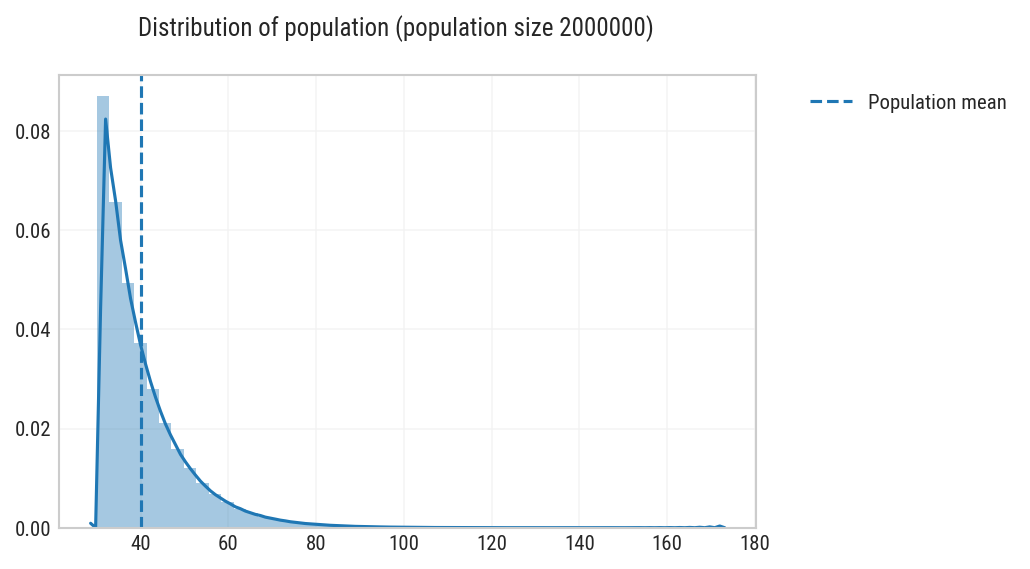

In [5]:
ax = sns.distplot(a=population)
ax.axvline(x=population_mean, color='C0', label='Population mean', ls='dashed')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gcf().suptitle(t="Distribution of population (population size {0})".format(POP_SIZE, y=1.01))


If we **draw a random sample** from this population, this is what it could look like.

Every time you run this cell we get a different random sample.

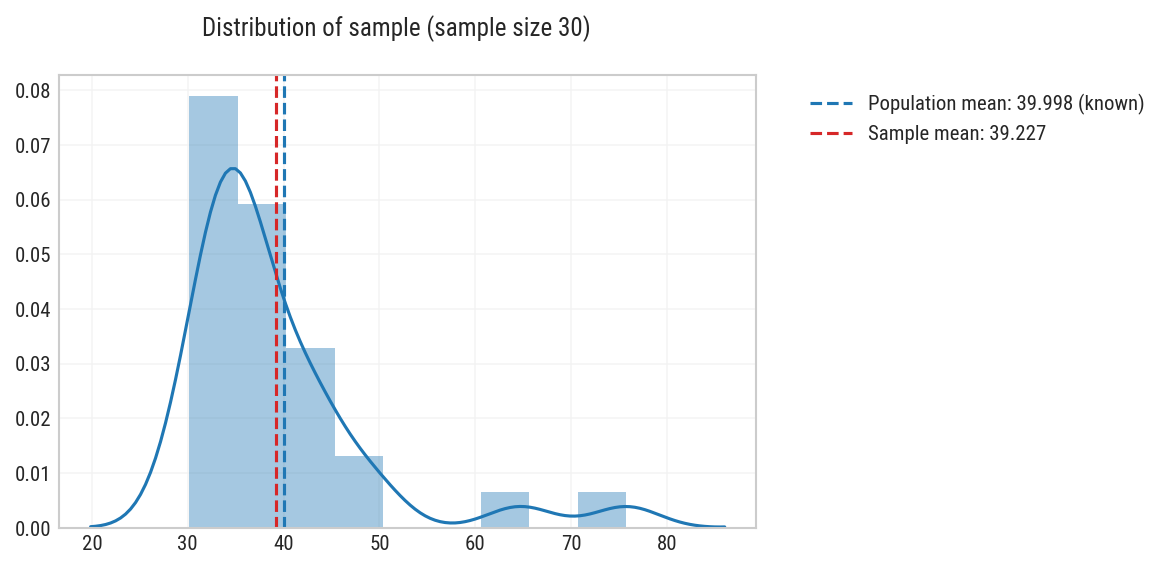

In [6]:
sample_size = 30

# we use the function that generate the population to generate this sample
# we therefore *know* that our sample comes from this population because we generated it that way
sample = population_fn.rvs(sample_size)
sample_mean = np.mean(sample)

# plot the sample alongside the population mean
ax = sns.distplot(a=sample)

ax.axvline(x=population_mean,
           color='C0',
           ls='dashed',
           label='Population mean: {0:.3f} (known)'.format(population_mean))

ax.axvline(x=sample_mean,
           color='C3', label='Sample mean: {0:.3f}'.format(sample_mean), linestyle='dashed')

plt.gcf().suptitle(t="Distribution of sample (sample size {0})".format(sample_size, y=1.01))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


We can see that the sample does not have the same shape _or_ mean as the population, even though we **know** that it comes from the above population (because we generated it that way). 

If we generate a fresh sample many times, we will see that it varies a lot and the `sample mean` is sometimes very close to the `population mean` while other times it's very far. 

Below, we wrap the bits above in a function to create an interactive plot so we can vary the sample size using the slider and see how our plot changes. 

In [7]:
def fn(pop_dist_name,
       pop_shape_kws,
       pop_size,
       sample_size):

    dist_func = getattr(stats, pop_dist_name)
    population_fn = dist_func(**pop_shape_kws)
    population = population_fn.rvs(pop_size)
    population_mean = np.mean(population)

    sample = population_fn.rvs(sample_size)
    sample_mean = np.mean(sample)

    fig = plt.figure()

    ax = sns.distplot(a=sample)

    ax.axvline(x=population_mean,
               color='C0',
               ls='dashed',
               label='Population mean: {0:.3f} (known)'.format(population_mean))

    ax.axvline(x=sample_mean,
               color='C3',
               label='Sample mean: {0:.3f}'.format(sample_mean), linestyle='dashed')

    fig.suptitle(t="Distribution of sample (sample size {0})".format(
        sample_size, y=1.01))

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    

As we drag the slider to the right the sample size increases and the sample shape becomes more similar to that of the population. 

The *sample mean also converges towards our population mean*.

In [8]:
sample_size_slider = ipywidgets.IntSlider(
    min=10,
    max=10000,
    step=10,
    value=10,
    layout=ipywidgets.Layout(width='500px', height='30px'),
    description='Sample size: ')

out = ipywidgets.interact(fn,
                    pop_dist_name=ipywidgets.fixed(POP_DIST_NAME),
                    pop_shape_kws=ipywidgets.fixed(POP_SHAPE_KWS),
                    pop_size=ipywidgets.fixed(POP_SIZE),
                    sample_size=sample_size_slider)

interactive(children=(IntSlider(value=10, description='Sample size: ', layout=Layout(height='30px', width='500px'), max=10000, min=10, step=10), Output()), _dom_classes=('widget-interact',))

## Central Limit Theorem

Central Limit Theorem says that the sampling distribution of the sample mean (treated here as a **random variable in its own right with its own distribution**) converges to the normal distribution as the size of original sample increases, _regardless of the distribution of the original data_.

In other words, if we:

1. Draw a large number of samples from some function

2. Calculate the mean of each one sample

3. Plot the distribution of means (this is the `sampling distribution of the mean`)

Then this distribution would approximate the normal distribution.

The center of this distribution converges towards the population mean. Let's look at some examples:

In [9]:
def sample_stats(pop_dist_name,
                 pop_shape_kws,
                 pop_size,
                 n_samples,
                 sample_size,
                 stat='mean',
                 ci=False,
                 confidence=95):

    fns = {
        'mean': np.mean,
        'sum': np.sum,
        'median': np.median,
        'max': np.amax,
        'min': np.amin,
        'std': np.std,
        'var': np.var
    }

    stat_func = fns[stat]

    dist_func = getattr(stats, pop_dist_name)
    population_fn = dist_func(**pop_shape_kws)
    population = population_fn.rvs(pop_size)
    population_stat = stat_func(population)

    statistics = list()

    for idx in range(n_samples):
        sample = population_fn.rvs(sample_size)
        sample_stat = stat_func(sample)
        statistics.append(sample_stat)

    if ci:
        hi = (1 + confidence / 100.0) / 2 * 100
        lo = 100 - hi

        ci_hi = np.percentile(statistics, hi)
        ci_lo = np.percentile(statistics, 100 - hi)

    mean_statistics = np.mean(statistics)

    fig = plt.figure()

    ax = sns.distplot(a=statistics)

    if stat != 'sum':
        ax.axvline(x=population_stat,
                   color='C0',
                   ls='dashed',
                   label='Population {1}: {0:.3f} (known)'.format(population_stat, stat))

    ax.axvline(x=mean_statistics,
               color='C3',
               label='Mean of sample {1}s: {0:.3f}'.format(mean_statistics, stat))

    if ci:
        ax.axvline(x=ci_lo,
                   color='k',
                   linestyle='dashed',
                   label='empirical low CI limit: {:.3f}'.format(ci_lo))

        ax.axvline(x=ci_hi,
                   color='k',
                   linestyle='dashed',
                   label='empirical high CI limit: {:.3f}'.format(ci_hi))
        
    fig.suptitle(t="{2}s of {0} samples (of size {1} each)".format(
        n_samples, sample_size, stat), y=1.01)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    

For example, plot 50 random samples of 30 observations each:

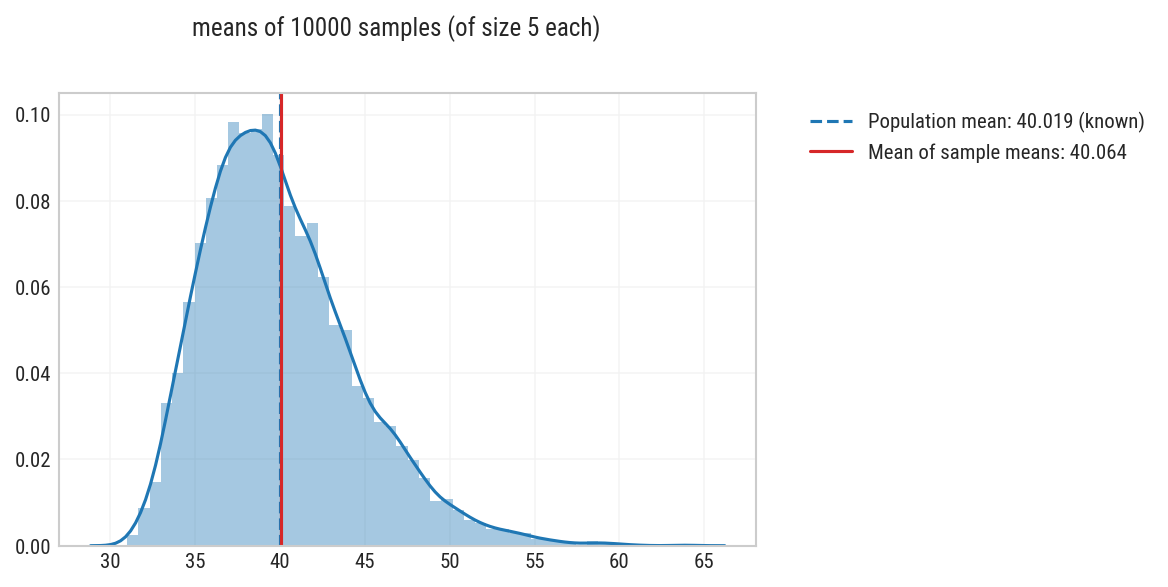

In [10]:
sample_stats(
    pop_dist_name=POP_DIST_NAME,
    pop_shape_kws=POP_SHAPE_KWS,
    pop_size=POP_SIZE,
    n_samples=10000,
    sample_size=5,
    stat='mean')

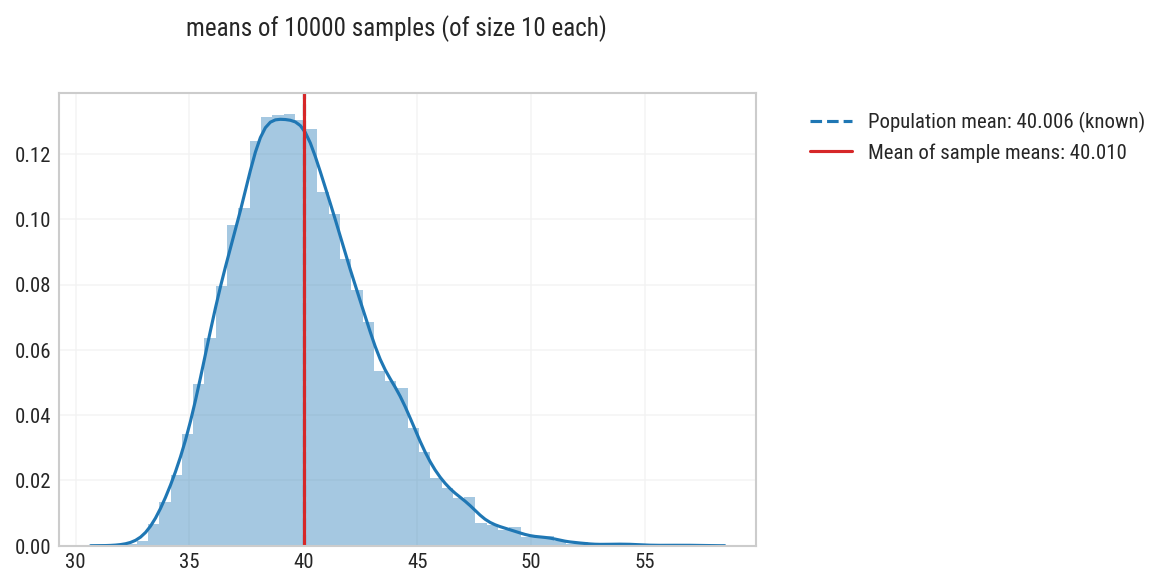

In [11]:
sample_stats(
    pop_dist_name=POP_DIST_NAME,
    pop_shape_kws=POP_SHAPE_KWS,
    pop_size=POP_SIZE,
    n_samples=10000,
    sample_size=10,
    stat='mean')

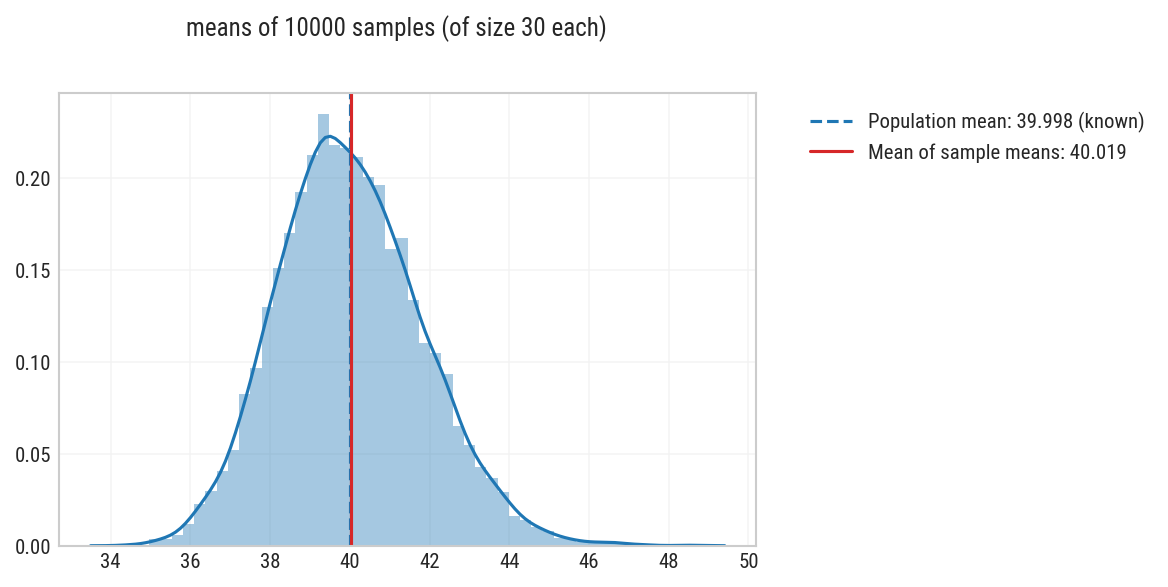

In [12]:
sample_stats(
    pop_dist_name=POP_DIST_NAME,
    pop_shape_kws=POP_SHAPE_KWS,
    pop_size=POP_SIZE,
    n_samples=10000,
    sample_size=30,
    stat='mean')

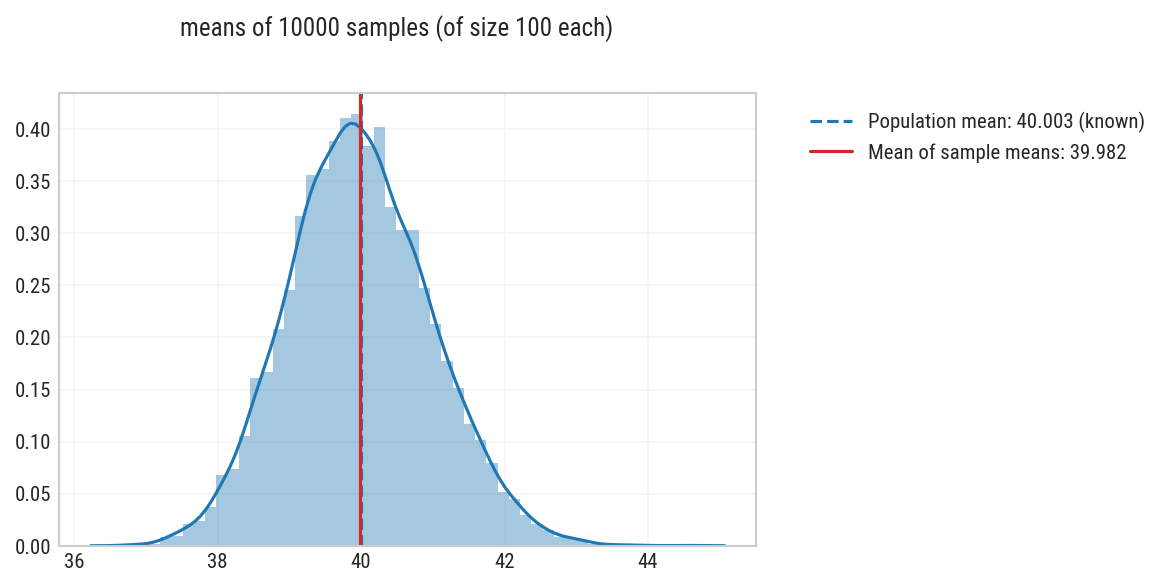

In [13]:
sample_stats(
    pop_dist_name=POP_DIST_NAME,
    pop_shape_kws=POP_SHAPE_KWS,
    pop_size=POP_SIZE,
    n_samples=10000,
    sample_size=100,
    stat='mean')

We can see that:

1. The distribution of means converges to the normal distribution 

2. The mean of means converges towards the population mean 

The above holds true if **we collect lots of samples, regardless of sample size** (although the higher the sample size, the more normal the distribution of means looks like).

Now let's use a simulator to gain some intuition.

In [14]:
sample_size_slider = ipywidgets.IntSlider(
    min=10,
    max=1000,
    step=10,
    value=15,
    layout=ipywidgets.Layout(width='500px', height='30px'),
    description='Sample size:')

n_samples_slider = ipywidgets.IntSlider(
    min=10,
    max=10000,
    step=10,
    value=500,
    layout=ipywidgets.Layout(width='500px', height='30px'),
    description='N samples:')

confidence_slider = ipywidgets.IntSlider(
    min=0,
    max=100,
    step=1,
    value=95,
    layout=ipywidgets.Layout(width='500px', height='30px'),
    description='Confidence:')

stat_options = ipywidgets.Dropdown(
    options=['mean', 'median', 'sum', 'max', 'min', 'std', 'var'],
    description='Statistic:')

out = ipywidgets.interact(sample_stats,
                    pop_dist_name=ipywidgets.fixed(POP_DIST_NAME),
                    pop_shape_kws=ipywidgets.fixed(POP_SHAPE_KWS),
                    pop_size=ipywidgets.fixed(POP_SIZE),
                    n_samples=n_samples_slider,
                    sample_size=sample_size_slider,
                    stat=stat_options,
                    confidence=confidence_slider,
                    ci=True)

interactive(children=(IntSlider(value=500, description='N samples:', layout=Layout(height='30px', width='500px'), max=10000, min=10, step=10), IntSlider(value=15, description='Sample size:', layout=Layout(height='30px', width='500px'), max=1000, min=10, step=10), Dropdown(description='Statistic:', options=('mean', 'median', 'sum', 'max', 'min', 'std', 'var'), value='mean'), Checkbox(value=True, description='ci'), IntSlider(value=95, description='Confidence:', layout=Layout(height='30px', width='500px')), Output()), _dom_classes=('widget-interact',))

Crucially, if the distribution of means resembles the normal distribution, we can use the theoretical properties of the normal distribution and in particular the fact that 95% of the distribution lies between the 2.5th and 97.5th percentiles.

So __if__ we had the ability to draw many many samples from an unknown population, calculated their means and plotted their distribution, we would know that if we repeated the process 100 times, 95 times out of a hundred our true population mean would lie between the 2.5th and 97.5th percentiles of this sampling distribution __if this sampling distribution is approximately normal__.

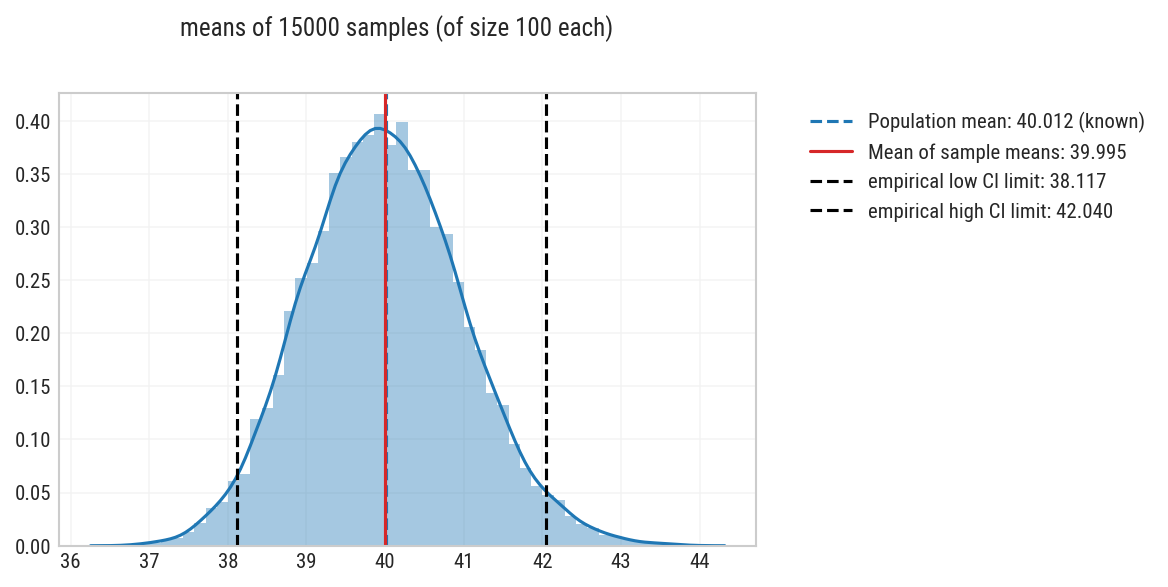

In [15]:
sample_stats(
    pop_dist_name=POP_DIST_NAME,
    pop_shape_kws=POP_SHAPE_KWS,
    pop_size=POP_SIZE,
    n_samples=15000,
    sample_size=100,
    ci=True,
    confidence=95,
    stat='mean')

## The bootstrap in a nutshell

So what is the bootstrap? In a nutshell, if we have a __large enough sample__, we can:
    
1. __Treat our sample as if it were the population__ (smart people have proven that this is a valid assumption if the sample is large).

2. Draw a large number of samples from it __as if we were drawing them from the population__.

3. Calculate their means and plot the distribution of the means (bootstrap distribution).

4. Use the bootstrap distribution to calculate a confidence interval around the mean. Around 95% of the time this CI will contain the *true population mean*.

The bootstrap rocks because:

1. It can be used with a wide variety of statistics not just the mean but also median, trimmed mean, etc (classical statistical methods like ttest only work for the mean).

2. It makes **no assumptions** about the underlying distribution of the data. 

People who code love the bootstrap because you can pass a different statistic (mean, median etc) on the fly without coding in silly exceptions for different kinds of data.

However, the __bootstrap fails _if_ the sample is not large enough to begin with__. If it's not large enough then it's less likely that it will be representative of the population to begin with. The process of bootstrapping will still work but the confidence interval that it produces may easily miss the true population mean entirely.

## How to run a basic bootstrap and calculate confidence interval

### How does resampling with replacement work?

Let's generate some fake data, an array of 10 values

In [16]:
data = np.array([4, 4, 5, 4, 2, 2, 19, 10, 3, 4, 3, 10, 27, 5, 2, 2, 5, 2, 4, 10])
data_size = data.shape[0]
print("number of values in data: {}".format(data_size))
print("mean of data: {}".format(np.mean(data)))

number of values in data: 20
mean of data: 6.35


When we randomly draw a number from it, each of the 20 values has an equal probability of being drawn, `1/20` more precisely.

However, as some of the values occur more than once -- like `2` which appears several times -- , the probability of drawing a 2 is much greater than the probability of drawing a 3 (which occurs only once).

Try drawing a random number by running the cell below several times:

In [17]:
one_value = np.random.choice(data, size=1)
one_value

array([2])

In resampling with replacement we draw a sample of **the same size** from the original data, but **with replacement**. 

This means that we draw a sample of 20 from our original sample of 20. And each time we draw a value, it might:

* be drawn more than once

* not be drawn at all

Run the cell below several times to get random resamples of the data. 

Notice that we get 20 values back and some values may occur more than others while some of the original values may occur at all.

In [18]:
resample = np.random.choice(data, size=data_size, replace=True)
resample

array([ 5,  5,  5, 10,  3,  5,  5, 27, 10,  2,  4,  5,  5,  4, 10, 10,  2,
        3,  4,  4])

Let's draw 10 resamples:

In [19]:
for i in range(10):
    resample = np.random.choice(data, size=data_size, replace=True)
    print("\nresample: {},\nmean: {}".format(resample, np.mean(resample)))
    
    
print("\nmean of original data: {}".format(np.mean(data)))


resample: [ 3 27  2  2  5  4 10  4  4 19  2 10 10 10  4  3 10  4  4  2],
mean: 6.95

resample: [ 3 19 10  5 10 10  4  2  2  5 10  4  3 10  2 10  2  2 27  2],
mean: 7.1

resample: [ 2 27  3 19  4 10  2  2  4  2  2  2 10  4  2  2  5 27  4  4],
mean: 6.85

resample: [ 3 10  2  3  2  3  2 19  4 10 19 27 27  2  2  4 10  5  5  2],
mean: 8.05

resample: [ 2  5  4 10  4 27  3  2  4  4  2 19  4 10  2  4  2  4 19  5],
mean: 6.8

resample: [ 5  3  2  4  2  4  2  2  5  2  5 19 27  2  3  2  4  2  4  4],
mean: 5.15

resample: [ 4  4  3  3  2  2  3  2  4 19  5  3  4  4 19  4  4 10  4  3],
mean: 5.3

resample: [ 2  2  5  4 19  4  5  5  4  2 10 10 10  2 10  5  3 10  4  3],
mean: 5.95

resample: [ 2  5  4  2  2  5  2  5  5  5  2  3  3  4  4  2  4 10  3  2],
mean: 3.7

resample: [ 4  2 19  5  2 19  3  2 10  3  4  5  2 27 10 10  2  2  4 19],
mean: 7.7

mean of original data: 6.35


We can can see above that the means of the 10 resamples are not too far off from the mean of our original data from which we resampled. This is the core principle behind the bootstrap at work. 

What if we re-run the process many more times, about 10000 times.

### The bootstrap at work

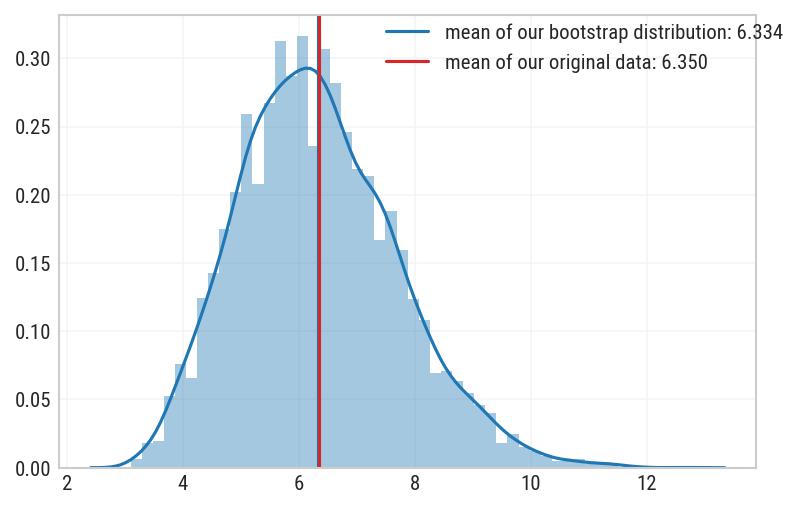

In [20]:
means = list()
for i in range(10000):
    resample = np.random.choice(data, size=data_size, replace=True)
    means.append(np.mean(resample))

ax = sns.distplot(a=means)
ax.axvline(x=np.mean(means), color='C0', label='mean of our bootstrap distribution: {:.3f}'.format(np.mean(means)))
ax.axvline(x=np.mean(data), color='C3', label='mean of our original data: {:.3f}'.format(np.mean(data)))
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.0)


Why the **bootstrap** works:
    
* The **less common a value is in the original data**, the *less likely it is that it will get picked during resampling*. Even if it does get picked and they influence the mean of the resample, it will likely affect a small number of resamples which will have little effect over the resulting bootstrap distribution of the means (and ultimately it's the distribution we care about, _not_ individual resamples).

* The **more common a value is in the original data**, the *more likely it is that it will get picked during resampling*. Therefore the means of bootstrap distribution will reflect the values which occur most frequently, and therefore be more representative of the center of the original sample which in turn is likely to be representative of the population where that value was drawn from.

In [21]:
def bootstrap(pop_dist_name,
              pop_shape_kws,
              pop_size,
              n_resamples,
              original_sample_size,
              confidence=95,
              stat='mean'):

    fns = {
        'mean': np.mean,
        'sum': np.sum,
        'median': np.median,
        'max': np.amax,
        'min': np.amin,
        'std': np.std,
        'var': np.var
    }

    stat_func = fns[stat]

    dist_func = getattr(stats, pop_dist_name)
    population_fn = dist_func(**pop_shape_kws)
    population = population_fn.rvs(pop_size)

    population_stat = stat_func(population)

    # draw one single sample from the population
    # which we will then treat as if it were the population
    # and from which we will draw resamples
    original_sample = population_fn.rvs(original_sample_size)

    # the statistic of the original sample (e.g. mean/median)
    original_sample_stat = stat_func(original_sample)

    # plot distribution of original sample
    fig = plt.figure()
    ax = sns.distplot(a=original_sample)

    if stat != 'sum':
    
        ax.axvline(x=population_stat,
                   color='C0',
                   ls='dashed',
                   label='Population {1}: {0:.3f} (known)'.format(population_stat, stat))

    ax.axvline(x=original_sample_stat,
               color='C3',
               ls='dashed',
               label="{} of original sample: {:.3f}".format(stat, original_sample_stat))

    fig.suptitle(t="Distribution of original sample (sample size {0})".format(
        original_sample_size,
        y=1.01))

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    

    statistics = list()
    for idx in range(n_resamples):
        # we draw a resample with replacement from the original sample we drew from the population
        resample = np.random.choice(original_sample,
                                    size=original_sample_size,
                                    replace=True)

        # calculate the mean (or some other statistic)
        resample_stat = stat_func(resample)

        # save it later
        statistics.append(resample_stat)

    # calculate the center of the bootstrap distribution of all resample means (or some other statistic)
    mean_statistics = np.mean(statistics)

    # calculate confidence interval around the mean, 95% of the time this will include the true population mean
    hi = (1 + confidence / 100.0) / 2 * 100
    lo = 100 - hi

    ci_hi = np.percentile(statistics, hi)
    ci_lo = np.percentile(statistics, 100 - hi)

    fig = plt.figure()

    ax = sns.distplot(a=statistics)

    if stat != 'sum':
        ax.axvline(x=population_stat,
                   color='C0',
                   ls='dashed',
                   label='Population {1}: {0:.3f} (known)'.format(population_stat, stat))

    ax.axvline(x=mean_statistics,
               color='C3',
               label='Mean of sample {1}s: {0:.3f}'.format(mean_statistics, stat))

    ax.axvline(x=original_sample_stat, color='C1',
               label='Original sample {1}: {0:.3f}'.format(original_sample_stat, stat))

    ax.axvline(x=ci_lo,
               color='k',
               linestyle='dashed',
               label='bootstrap low CI limit: {:.3f} (percentile method)'.format(ci_lo))
    
    ax.axvline(x=ci_hi,
               color='k',
               linestyle='dashed',
               label='bootstrap high CI limit: {:.3f} (percentile method)'.format(ci_hi))

    fig.suptitle(t="{2}s of {0} resamples (drawn from original sample size {1})".format(
        n_resamples, original_sample_size, stat),
        y=1.01)

    fig.text(s="{2}% confidence interval around original sample {1}: {0}".format((ci_lo, ci_hi),
                                                                                 stat,
                                                                                 confidence),
             verticalalignment='center',
             horizontalalignment='center',
             color='black',
             x=0.5,
             y=0,
             wrap=True)

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    

Below we can see that the more resamples we draw, the more the mean of the distribution of resample means will converge towards the `mean of the original sample`. 

However, even with a very large original sample size, the bootstrap distribution **does not necessarily center at the population mean**. 

However, if the original sample is large enough and the bootstrap distribution is approx normal, then we can say that the true population mean lies somewhere between the 2.5th and 97.5th percentiles in this distribution.

In [22]:
original_sample_size_slider = ipywidgets.IntSlider(
    min=10,
    max=10000,
    step=10,
    value=10,
    layout=ipywidgets.Layout(width='500px', height='30px'),
    description="Sample size:")

n_resamples_slider = ipywidgets.IntSlider(
    min=10,
    max=15000,
    step=10,
    value=1000,
    layout=ipywidgets.Layout(width='500px', height='30px'),
    description="N resamples:")

stat_options = ipywidgets.Dropdown(
    options=['mean', 'median', 'sum', 'max', 'min', 'std', 'var'],
    description='Statistic:')

out = ipywidgets.interact(bootstrap,
                          pop_dist_name=ipywidgets.fixed(POP_DIST_NAME),
                          pop_shape_kws=ipywidgets.fixed(POP_SHAPE_KWS),
                          pop_size=ipywidgets.fixed(POP_SIZE),
                          n_resamples=n_resamples_slider,
                          original_sample_size=original_sample_size_slider,
                          confidence=confidence_slider,
                          stat=stat_options)

interactive(children=(IntSlider(value=1000, description='N resamples:', layout=Layout(height='30px', width='500px'), max=15000, min=10, step=10), IntSlider(value=10, description='Sample size:', layout=Layout(height='30px', width='500px'), max=10000, min=10, step=10), IntSlider(value=95, description='Confidence:', layout=Layout(height='30px', width='500px')), Dropdown(description='Statistic:', options=('mean', 'median', 'sum', 'max', 'min', 'std', 'var'), value='mean'), Output()), _dom_classes=('widget-interact',))

# Intuition behind the bootstrap for proportions

TODO